In [ ]:
! pip3 install pyro-ppl 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive")
files = os.listdir("./")
# print(files)
if "Results" not in files:
  os.mkdir("./Results")
!ls Results/

1000_200_False_simple_model_False_try_num_4
1000_200_True_simple_model_False_try_num_4
200_100_True_simple_model_False_try_num_4
200_100_True_simple_model_True_try_num_4
250_100_True
250_100_True_simple_model_False_try_num_4
250_200_True
250_500_False_simple_model_True_try_num_1
250_500_False_simple_model_True_try_num_3
250_500_True
250_500_True_simple_model_False
250_500_True_simple_model_False_try_num_1
250_500_True_simple_model_False_try_num_4
250_500_True_simple_model_True
250_500_True_simple_model_True_try_num_1
250_500_True_simple_model_True_try_num_2
250_500_True_simple_model_True_try_num_3
250_500_True_simple_model_True_try_num_4
600_200_False_simple_model_False_try_num_4
600_200_True_simple_model_False_try_num_4
600_200_True_simple_model_True_try_num_4
Test


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from torch.distributions.multivariate_normal import MultivariateNormal

import torch
import torch.nn as nn
import pyro
from pyro.distributions import Binomial, Normal
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import bernoulli, binom
from sklearn import linear_model

from numpy import asarray
from numpy import savetxt

np.random.seed(33)

try_num = 4

# Size

n = 1000
d = 200
# K = 100
p = 0.5


REP = 500
total_beta_sample = 1000

num_epochs = 2000
EPSILON = 1
lambda_val = 0.05
BATCH_SIZE = 200


first = True
simple_model = False

#Genarating Genotypes

toy_genotypes = binom.rvs(2, p, size=(n * 3, d))
np.random.shuffle(toy_genotypes)

print(toy_genotypes.shape)

print(np.mean(toy_genotypes))
print(np.var(toy_genotypes))

RES_DICT = {'REP': REP, 'BATCH_SIZE': BATCH_SIZE}

(3000, 200)
1.0004366666666666
0.5004531426555555


In [ ]:
files = os.listdir("./Results")
save_file_name = str(n) + '_' + str(d) + '_' + str(first) + '_simple_model_' + str(simple_model) + '_try_num_' + str(try_num) 

if save_file_name not in files:
  os.mkdir("./Results/" + save_file_name)

os.chdir("Results/" + save_file_name)
!ls

betas.csv		  phenotypes_dist_together.pdf	train_phenotypes.csv
linear_model_res.pdf	  test_genotypes.csv		val_genotypes.csv
phenotypes_dist_cont.pdf  test_phenotypes.csv		val_phenotypes.csv
phenotypes_dist.pdf	  train_genotypes.csv


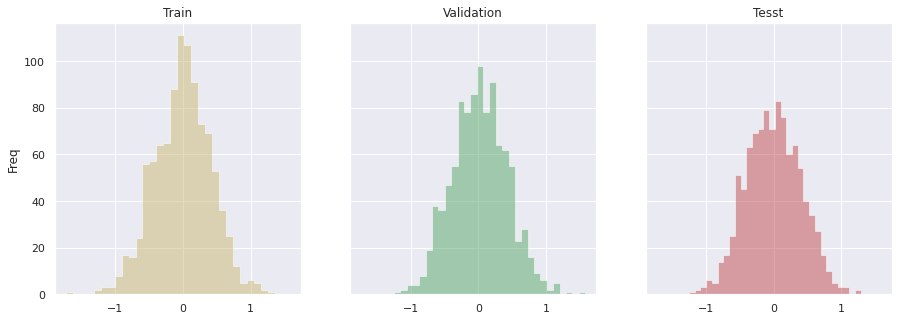

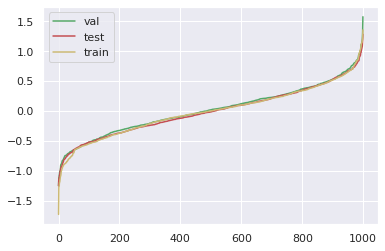

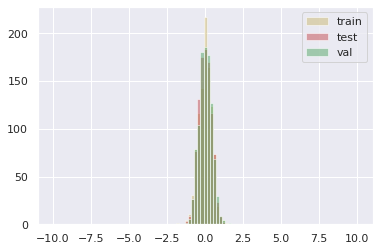

0.10790007368859549 validation
0.6238530078034714 validation correlation
0.0674017851263541 train
0.7847277841504033 train correlation
0.10032440757720328 test
0.6512591973759215 test correlation



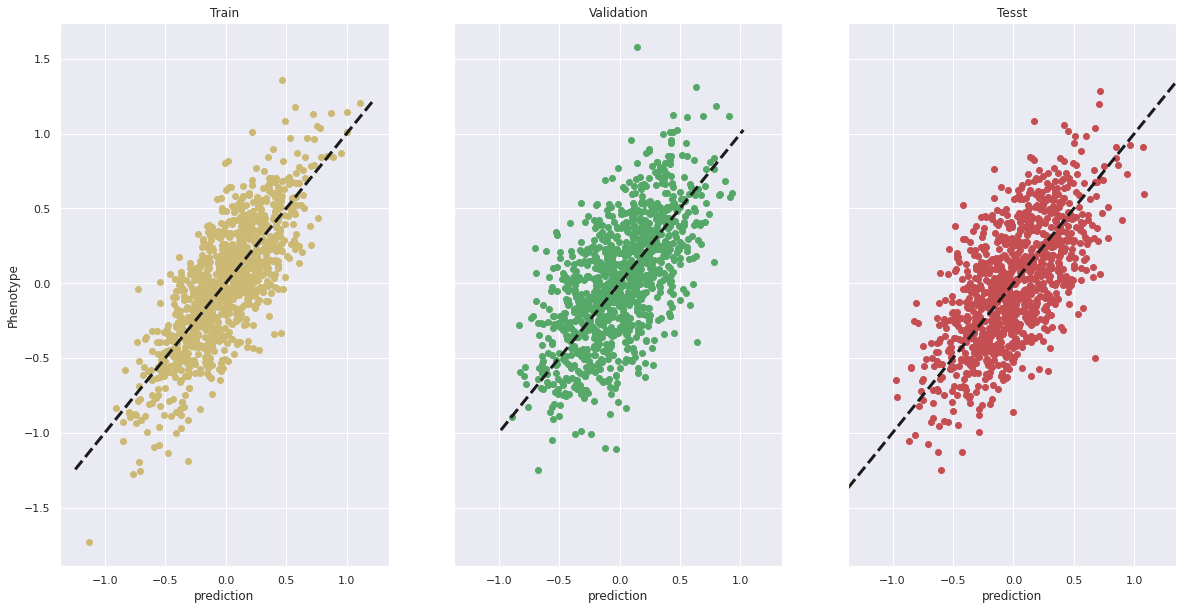

In [ ]:
def simulate_phenotypes(given_genotypes, pis=(0.95, 0.05), gammas=np.array((0., 1.)), mixture_assignment=None):
    
    
    n, p = given_genotypes.shape
    if mixture_assignment is None:
      mixture_assignment = np.random.multinomial(1, pis, size=p)
    
    std_beta = 1
    
    betas = np.random.normal(loc=0.0,
                             scale=gammas[np.where(mixture_assignment)[1]]*std_beta,
                             size=p)
    
    mult = np.dot(given_genotypes, betas)
    g_var = np.var(mult, ddof=1)
    
    e = np.random.normal(0, np.sqrt(g_var), n)
    
    y = mult + e

    y -= np.mean(y)
    y /= np.var(y)
  
    return y, betas, mixture_assignment



test_genotypes = toy_genotypes[0:n,:]
val_genotypes = toy_genotypes[n:2*n,:]
train_genotypes = toy_genotypes[2 * n:,:]

if first:

    toy_phenotypes, betas, mixtures = simulate_phenotypes(toy_genotypes)
    test_phenotypes = toy_phenotypes[0:n,]
    val_phenotypes = toy_phenotypes[n:2*n,]
    train_phenotypes = toy_phenotypes[2 * n:,]

    savetxt('./betas.csv', betas, delimiter=',')

    savetxt('./train_genotypes.csv', train_genotypes, delimiter=',')
    savetxt('./train_phenotypes.csv', train_phenotypes, delimiter=',')

    savetxt('./test_genotypes.csv', test_genotypes, delimiter=',')
    savetxt('./test_phenotypes.csv', test_phenotypes, delimiter=',')

    savetxt('./val_genotypes.csv', val_genotypes, delimiter=',')
    savetxt('./val_phenotypes.csv', val_phenotypes, delimiter=',')

else:
    test_phenotypes, betas_test, grand_mixture = simulate_phenotypes(test_genotypes)
    val_phenotypes, betas_val,_ = simulate_phenotypes(val_genotypes, mixture_assignment=grand_mixture)
    train_phenotypes, betas_train,_ = simulate_phenotypes(train_genotypes, mixture_assignment=grand_mixture)

    savetxt('./train_genotypes.csv', train_genotypes, delimiter=',')
    savetxt('./train_phenotypes.csv', train_phenotypes, delimiter=',')
    savetxt('./betas_train.csv', betas_train, delimiter=',')

    savetxt('./test_genotypes.csv', test_genotypes, delimiter=',')
    savetxt('./test_phenotypes.csv', test_phenotypes, delimiter=',')
    savetxt('./betas_test.csv', betas_test, delimiter=',')

    savetxt('./val_genotypes.csv', val_genotypes, delimiter=',')
    savetxt('./val_phenotypes.csv', val_phenotypes, delimiter=',')
    savetxt('./betas_val.csv', betas_val, delimiter=',')


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

axis[0].hist(train_phenotypes, color='y', bins=30, alpha=0.5, histtype='stepfilled')
axis[0].set_title("Train")

axis[1].hist(val_phenotypes, color='g', bins=30, alpha=0.5, histtype='stepfilled')
axis[1].set_title("Validation")

axis[2].hist(test_phenotypes, color='r', bins=30, alpha=0.5, histtype='stepfilled')
axis[2].set_title("Tesst")

for ax in axis.flat:
    ax.set(ylabel='Freq')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
plt.show()
figure.savefig('phenotypes_dist.pdf')

plt.plot(np.sort(val_phenotypes), color='g', label='val')
plt.plot(np.sort(test_phenotypes), color='r', label='test')
plt.plot(np.sort(train_phenotypes), color='y', label='train')
plt.legend(loc='upper left')
print("")
plt.savefig('phenotypes_dist_cont.pdf')
plt.show()

bins = np.linspace(-10, 10, 100)

plt.hist(train_phenotypes, bins, alpha=0.5, color='y', label='train')
plt.hist(test_phenotypes, bins, alpha=0.5, color='r', label='test')
plt.hist(val_phenotypes, bins, alpha=0.5, color='g', label='val')

plt.legend(loc='upper right')
plt.savefig('phenotypes_dist_together.pdf')
print("")
plt.show()

from sklearn import svm
from scipy.stats import pearsonr

reg = linear_model.Ridge(alpha=.5)
reg.fit(train_genotypes, train_phenotypes)


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10))

per = reg.predict(val_genotypes)

# plt.xticks(np.arange(-0.5, 0.5, 0.05))
# plt.yticks(np.arange(-0.5, 0.5, 0.01))

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

# EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)


RES_DICT['linear model validation'] = np.mean((val_phenotypes - per) ** 2)
print(np.mean((val_phenotypes - per) ** 2), 'validation')
print(pearsonr(val_phenotypes, per)[0], 'validation correlation')


del per

per = reg.predict(train_genotypes)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model train'] = np.mean((train_phenotypes - per) ** 2)
print(np.mean((train_phenotypes - per) ** 2), 'train')
print(pearsonr(train_phenotypes, per)[0], 'train correlation')


del per

per = reg.predict(test_genotypes)


axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
RES_DICT['linear model test'] = np.mean((test_phenotypes - per) ** 2)
print(np.mean((test_phenotypes - per) ** 2), 'test')
print(pearsonr(test_phenotypes, per)[0], 'test correlation')




for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
# plt.xlim(-1,1)
plt.show()
figure.savefig('linear_model_res.pdf')






In [ ]:
# beta_marginal.csv  LD.csv  X_train.csv	y_train.csv
# betas = betas_train

import pandas as pd
k = betas[betas != 0]
causal = list(pd.Series(betas)[pd.Series(betas).isin(k)].index)
causal

[4, 31, 59, 72, 88, 107, 157]

0.032336151544406694
7


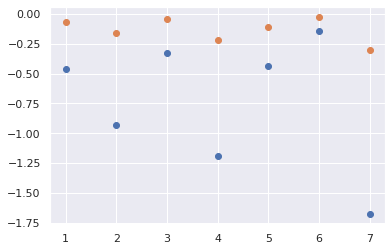

0.8973548967274629


In [ ]:

print(np.mean(np.abs(reg.coef_ - betas)))
print(len(betas[betas != 0]))
plt.scatter(np.arange(len(betas[betas != 0])) + 1, betas[betas != 0])
plt.scatter(np.arange(len(betas[betas != 0])) + 1, reg.coef_[betas != 0])

plt.show()

print(pearsonr(betas, reg.coef_)[0])

In [ ]:
class Loader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genotype_matrix, phenotypes, batch_size=1):

        self.phenotypes = phenotypes
        self.genotype_matrix = genotype_matrix

        self.batch_size = batch_size

    def __len__(self):
        return len(self.genotype_matrix)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        real_samples = self.genotype_matrix[idx, ]        
        samples = real_samples
        labels = self.phenotypes[idx, ]
        batch = {'x': samples.astype(np.float64), 'y': labels}

        return batch

    
    
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data    

dataset = Loader(train_genotypes, train_phenotypes)

from pyro.distributions import Normal, Gamma, MultivariateNormal
# from scipy.stats import gamma
alpha_gam = 2
beta_gam = 0.2

# from scipy.stats import norm


def prior_sample(size=1):
    gamma_dist = Gamma(alpha_gam, 1 / beta_gam)
    sigma = gamma_dist.sample(sample_shape=torch.Size([size]))

    normal_dist = Normal(0, sigma)
    beta = normal_dist.sample()
    return beta, sigma

def prior_prob(beta, sigma):
    gamma_dist = Gamma(alpha_gam, 1 / beta_gam, validate_args=True)
    p_sig = torch.exp(gamma_dist.log_prob(sigma))
    normal_dist = Normal(0, sigma)
    p_beta = torch.exp(normal_dist.log_prob(beta))
    
    return p_beta, p_sig


# from scipy.stats import multivariate_normal

def metropolis_heisting(cur_beta, cur_sigma, cur_prob_theta, geno_mat, h_classifier):
    
#     changed_value = np.full(cur_theta_prob.shape, 1)
    counter = 0

    while(True):
        new_beta = MultivariateNormal(cur_beta.float(), var.float()).sample()
        new_sigma = MultivariateNormal(cur_sigma.float(), var.float()).sample()

        # new_beta = torch.clip(new_beta, -2, 2)

        beta_prob, sigma_prob = prior_prob(new_beta, cur_sigma)
        new_ys = torch.matmul(geno_mat.float(), new_beta)
        with torch.no_grad():
            r_value = h_classifier(new_ys, geno_mat, new_beta, cur_sigma)
            r_value = torch.mean(r_value, dim=0)
            r_value = r_value / (1 - r_value)
            new_theta_prob = r_value * beta_prob * sigma_prob

            rho = ((new_theta_prob) / (cur_prob_theta + 1e-7)).cpu().detach().numpy()
            rho[rho > 1] = 1
    #         rho = rho * changed_value
    #        rho = min(1, (new_theta_prob)/(cur_theta_prob))
            random_num = np.random.rand()
            if np.isnan(np.sum(rho)):
                print("EROR ------------------------")
                print(np.isnan(np.sum(cur_prob_theta)))
                print(np.isnan(np.sum(new_prob_theta)))

            if random_num < np.mean(rho):
                cur_beta = new_beta
                cur_sigma = cur_sigma
                cur_theta_prob = new_theta_prob
                # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
                return cur_sigma, cur_beta, cur_theta_prob, new_ys

        counter += 1
        
        if counter > REP:
#             print("It Takes quite time :(")
            cur_beta = (new_beta + cur_beta) / 2
            cur_sigma = cur_sigma
            cur_theta_prob = (new_theta_prob + cur_prob_theta) / 2
            # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
            return cur_sigma, cur_beta, cur_theta_prob, new_ys

class Classifier(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(Classifier, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        # self.layer_1 = nn.Linear(input_dim, 1)
        # self.act1 = nn.ReLU()
        self.layer_out = nn.Linear(2, 1)
        self.out = nn.LogSoftmax(dim=1)
        

        self.criterion = nn.BCEWithLogitsLoss()
        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, genotypes_batch, beta, label=None, testing=False):

        y = torch.tensor(y).to(device).float()
        beta = torch.Tensor(beta).to(device)[:, None].float()
        genotypes_batch = torch.tensor(genotypes_batch).to(device).float()

        comparison_vector = torch.matmul(genotypes_batch, beta)
        
        # beta_summaries = self.act1(self.layer_1(beta))

        # x = torch.cat([y[:, None], torch.repeat_interleave(beta_summaries[None, :], y.shape[0], dim=0)], dim=1)
        x = torch.cat([y[:, None], comparison_vector], dim=-1)

        x = self.layer_out(x)

        logits = self.out(x)

        if label is not None:
            probs = torch.exp(logits) + 1e-6  
            if testing:
              labels = probs.clone().squeeze()
              labels[labels >= 0.5] = 1
              labels[labels < 0.5] = 0
              print(torch.sum(torch.abs(labels - label)), "Wrong Preds out of", len(label))

              return [], []

            loss = self.criterion(probs, label[:, None])
            return probs, loss
        
        return torch.exp(logits[:,-1]) + 1e-6
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp


class LogisticRegression(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(LogisticRegression, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.

        self.discriminator = nn.Sequential(nn.Conv1d(1, 32, kernel_size=6, stride=3),
                                           nn.LeakyReLU(0.2, inplace=0.2),
                                           nn.Dropout(0.5),
                                           nn.Conv1d(32, 16, kernel_size=6, stride=3),
                                           nn.LeakyReLU(0.2, inplace=True),
                                           nn.Dropout(0.3),
                                           nn.Conv1d(16, 4, kernel_size=6, stride=3),
                                           nn.LeakyReLU(0.2, inplace=True),
                                           nn.Dropout(0.1),
                                           nn.Conv1d(4, 1, kernel_size=6, dilation=2),
                                           nn.LeakyReLU(0.2, inplace=True))

        self.layer_out = nn.Sequential(nn.Linear(6, 1),
                                       nn.Sigmoid())
        
        # self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.1)
        # self.batchnorm1 = nn.BatchNorm1d(64)
        # self.batchnorm2 = nn.BatchNorm1d(64)

        self.criterion = torch.nn.BCELoss(size_average=False)

        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, genotypes_batch, beta, sigma, label=None, testing=False):

        y = torch.tensor(y).to(device).float()
        beta = torch.tensor(beta).to(device).float()
        sigma = torch.tensor(sigma).to(device).float()
        
        gamma_dist = Gamma(alpha_gam, 1 / beta_gam)
        sigma_n = gamma_dist.sample(sample_shape=sigma.shape)

        normal_dist = Normal(0, sigma_n)
        beta_f = normal_dist.sample()
        genotypes_batch = torch.tensor(genotypes_batch).to(device).float()

        pheno_fake_f = torch.matmul(genotypes_batch, beta)[:, None]
        pheno_fake_s = torch.matmul(genotypes_batch, beta_f)[:, None]
        y = y[:, None]


        # y = torch.Tensor(y).to(device)
        # beta = torch.Tensor(beta).to(device)
        
        # y = torch.repeat_interleave(y[:, None], d, dim=-1)
        # beta = torch.repeat_interleave(beta[None, :], y.shape[0], dim=0)
        
        x = torch.cat([beta, sigma], dim=-1)[None, None, :]
        
#         out = self.linear(x)
#         out = self.activation(out)
        x = self.discriminator(x).squeeze()

        # print(x.shape)

        x = torch.repeat_interleave(x[None, :], y.shape[0], dim=0)
        lab_vec = torch.cat([y, pheno_fake_f, pheno_fake_s], dim=-1)
        aux_loss = nn.MSELoss()(x, lab_vec)
        x = torch.cat([x, lab_vec], dim=-1)

        # x = self.batchnorm1(x)

        # x = self.batchnorm2(x)
        # x = self.dropout(x)
        # x = torch.squeeze(self.layer_out(x))

        probs = self.layer_out(x)

        # print(x[x>0].shape, "CLASSIFIER")
        # input()
        
        if label is not None:

            loss = self.criterion(probs, label[:, None])

            if testing:
              predicted = torch.round(probs).squeeze()
              print(float((len(label) - torch.sum(torch.abs(predicted - label)))) / len(label) * 100.0, " % acc")

              return torch.sum(torch.abs(predicted - label))

            return probs, loss + aux_loss
        
        return probs
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Running\ on the CPU
1
3732


  0%|          | 0/2000 [00:00<?, ?it/s]

---------
Validation distance: 0.20310253048099539
Validation correlation: 0.045199558496802385
EPOCH 0
Total Error tensor(830.7801, grad_fn=<DivBackward0>)
0 LEN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:224: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(

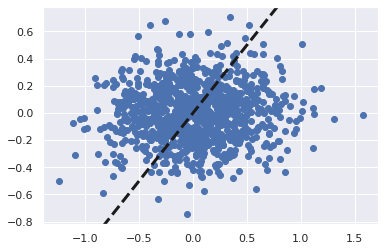

 25%|██▍       | 499/2000 [00:52<02:21, 10.59it/s]


78.9  % acc
96.8  % acc
87.8499984741211 %
Best modedl changed
---------
Validation distance: 0.3268799547385855
Validation correlation: 0.35847768955403525
EPOCH 500
Total Error tensor(805.1531, grad_fn=<DivBackward0>)
20 LEN


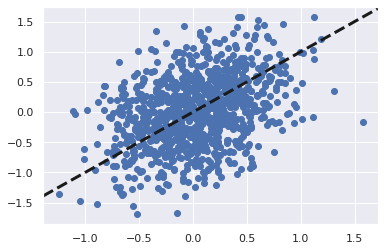

 50%|█████     | 1000/2000 [01:37<01:31, 10.94it/s]


78.60000000000001  % acc
97.2  % acc
87.90000081062317 %
Best modedl changed
---------
Validation distance: 0.5101172718784751
Validation correlation: 0.45846023357949606
EPOCH 1000
Total Error tensor(725.3940, grad_fn=<DivBackward0>)
49 LEN


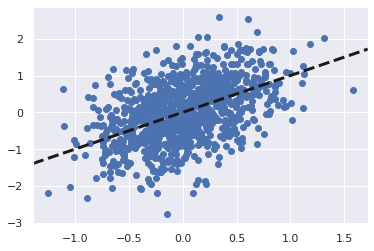

 75%|███████▌  | 1500/2000 [02:22<00:45, 10.94it/s]


12.0  % acc
58.699999999999996  % acc
35.350000858306885 %
---------
Validation distance: 0.6123287117250208
Validation correlation: 0.5022306638192947
EPOCH 1500
Total Error tensor(691.0499, grad_fn=<DivBackward0>)
67 LEN


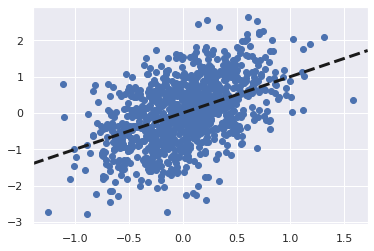

100%|██████████| 2000/2000 [03:08<00:00, 10.63it/s]


In [ ]:
threshold = 1
# cor_thresh = 0.6
d = train_genotypes.shape[1]
print_freq = 4

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running\ on the CPU")


data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

if simple_model:
  classifier = Classifier(d).to(device)
else:
  classifier = LogisticRegression(d * 2).to(device)

print(classifier.get_n_params())

optimizer = optim.Adam(classifier
                         .parameters(), lr=0.0002)

losses = []
distances = []

denum = train_genotypes.shape[0] / BATCH_SIZE

losses = []


# Sampling beta
proper_beta_samples = []
proper_sigma_samples = []
# proper_beta_samples_distances = []

all_beta = []

counter = 0

# RES_DICT['total_beta_sample'] = total_beta_sample


distance = -1


##### Saving
min_dist = 0
best_model = None

var = torch.tensor(np.eye(d) * (0.5 / d), dtype=torch.float64)

for epoch in tqdm(range(num_epochs)):
    
    error_sum = 0
    distance_sum = 0
    
#     var = np.eye(d) * (0.75 / (epoch + 1))

    cur_beta, cur_sigma = prior_sample(d)

    cur_ys = np.dot(train_genotypes, cur_beta)
    cur_ys -= np.mean(cur_ys)
    cur_ys /= np.var(cur_ys)
    beta_prob, sigma_prob = prior_prob(torch.tensor(cur_beta), torch.tensor(cur_sigma))
    # cur_r_value = classifier(cur_ys, train_genotypes.astype(np.float64), cur_beta).cpu().detach().numpy()
    # cur_r_value = np.mean(cur_r_value, axis=0)
    cur_r_value = classifier(cur_ys, train_genotypes.astype(np.float64), cur_beta, cur_sigma)

    cur_r_value = torch.mean(cur_r_value, dim=0)
    cur_r_value = cur_r_value / (1 - cur_r_value)

    cur_theta_prob = cur_r_value * beta_prob * sigma_prob

    for n_batch, batch in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        N = batch['x'].size(0)
        
        geno_batch = batch['x']
        pheno_batch = batch['y']
        
        sampled_sigma, sampled_beta, prob_theta, sampled_y, = metropolis_heisting(cur_beta, cur_sigma, cur_theta_prob, geno_batch, classifier)
#         sampled_y = torch.sigmoid(torch.tensor(sampled_y)).numpy()
        
#         sampled_y = sampled_y
        sampled_y -= sampled_y.mean()
        sampled_y /= sampled_y.std()

        # sampled_y *= -1

        distance = torch.mean((sampled_y - pheno_batch) ** 2)
        correlation = pearsonr(pheno_batch, sampled_y)[0]

        
#         print(distance)
        distance_sum += distance
        
        _, loss_f = classifier(sampled_y, geno_batch, sampled_beta, sampled_sigma, label=torch.full(sampled_y.shape, 0.0))
        _, loss_r = classifier(pheno_batch, geno_batch, sampled_beta, sampled_sigma, label=torch.full(pheno_batch.shape, 1.0))
        
#         _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
#         loss_f *= ((distance ** 2))
                             
#         _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
#         loss_r *= ((distance ** 2))
        
        loss = loss_f + loss_r
        loss *= (distance ** 2)

        # loss += lambda_val * torch.mean(torch.abs(sampled_beta))
        # / d + torch.mean((sampled_beta - betas) ** 2))

        loss.backward()

        optimizer.step()
        error_sum += loss

        # proper_beta_samples.append(sampled_beta.cpu().detach().numpy())
        if distance < 1:
          all_beta.append(sampled_beta.cpu().detach().numpy())

        if distance < threshold:
          proper_beta_samples.append(sampled_beta.cpu().detach().numpy())
          proper_sigma_samples.append(sampled_sigma.cpu().detach().numpy())

        # proper_beta_samples_dist[distance] = sampled_beta.cpu().detach().numpy()

        cur_beta = sampled_beta.clone()
        cur_sigma = sampled_sigma.clone()
        cur_theta_prob = prob_theta

    proper_beta_samples_val = np.array(proper_beta_samples)
    proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)

    proper_sigma_samples_val = np.array(proper_sigma_samples)
    proper_sigma_samples_val = np.mean(proper_sigma_samples_val, axis=0)
    
    if len(proper_beta_samples) > 0:
            # print("Using proper sets")
            proper_beta_samples_val = np.array(proper_beta_samples)
            proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)

            proper_sigma_samples_val = np.array(proper_sigma_samples)
            proper_sigma_samples_val = np.mean(proper_sigma_samples_val, axis=0)

            val_y = np.dot(val_genotypes, proper_beta_samples_val)

    else:   
            proper_beta_samples_val = np.array(sampled_beta)
            proper_sigma_samples_val = np.array(sampled_sigma)

            val_y = np.dot(val_genotypes, sampled_beta)
  
    val_y -= np.mean(val_y)
    val_y /= np.var(val_y)

    val_distance = np.mean((val_y - val_phenotypes) ** 2)
    val_correlation = pearsonr(val_phenotypes, val_y)[0]
    
    if (epoch % int(num_epochs / print_freq) == 0 and epoch >= int(num_epochs / print_freq)) or epoch == 0:
        if epoch > 0:
          print()
          # print(proper_beta_samples_val.shape)
          # print(val_genotypes.shape)
          # print(val_y.shape)
          wrongs_f = classifier(val_y, val_genotypes, proper_beta_samples_val, proper_sigma_samples_val, label=torch.full(val_y.shape, 0.0), testing=True)
          wrongs_r = classifier(val_phenotypes, val_genotypes, proper_beta_samples_val, proper_sigma_samples_val, label=torch.full(val_phenotypes.shape, 1.0), testing=True)
          acc = float(((len(val_y) + len(val_phenotypes) - (wrongs_f + wrongs_r)) / (len(val_y) + len(val_phenotypes))).detach().numpy())
          print(acc * 100, '%')
          if min_dist < acc:
            min_dist = acc
            best_model = torch.save(classifier.state_dict(), "./best_modedl.pt")
            print("Best modedl changed")
          

          # threshold = val_distance
          # cor_thresh = val_correlation  

          # print(threshold)
          # print(cor_thresh, "CORR")

        print("---------")
        print("Validation distance:", val_distance)
        print("Validation correlation:", val_correlation)
        print("EPOCH", epoch)
        print("Total Error", error_sum / n_batch) ####
        print(len(proper_beta_samples), 'LEN')


        plt.scatter(val_phenotypes, val_y)
        xpoints = ypoints = plt.xlim()
        plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
        plt.show()
#     print(distance_sum / denum)
        
    losses.append([error_sum / denum])
    distances.append([distance_sum / denum])
        

(84, 200)
(200,)


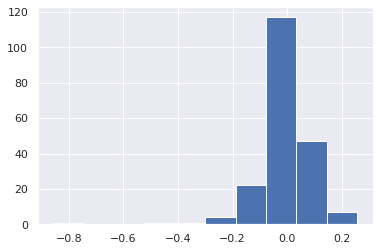

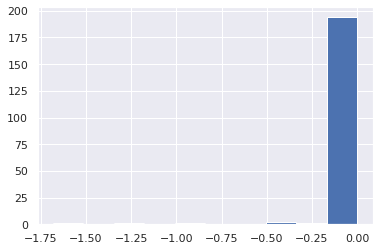

In [ ]:

savetxt('./betas_sample.csv', proper_beta_samples, delimiter=',')
proper_beta_samples_cop = proper_beta_samples.copy()

# proper_beta_samples = proper_beta_samples_cop[10:]

proper_beta_samples_np = np.array(proper_beta_samples).T

# proper_beta_samples_np -= np.mean(proper_beta_samples_np, axis=1)
# proper_beta_samples_np /= np.var(proper_beta_samples_np, axis=1)

print(proper_beta_samples_np.T.shape)
proper_beta_samples_mean = np.mean(proper_beta_samples_np.T, axis=0)
print(proper_beta_samples_mean.shape)

# proper_beta_samples_mean -= np.mean(proper_beta_samples_mean)
# proper_beta_samples_mean /= np.var(proper_beta_samples_mean)
# proper_beta_samples_mean[np.abs(proper_beta_samples_mean) < 0.9] = 0
# print(len(proper_beta_samples_mean[proper_beta_samples_mean > 0]))


plt.hist(proper_beta_samples_mean)
plt.show()
plt.hist(betas)
plt.show()



200
(84,)


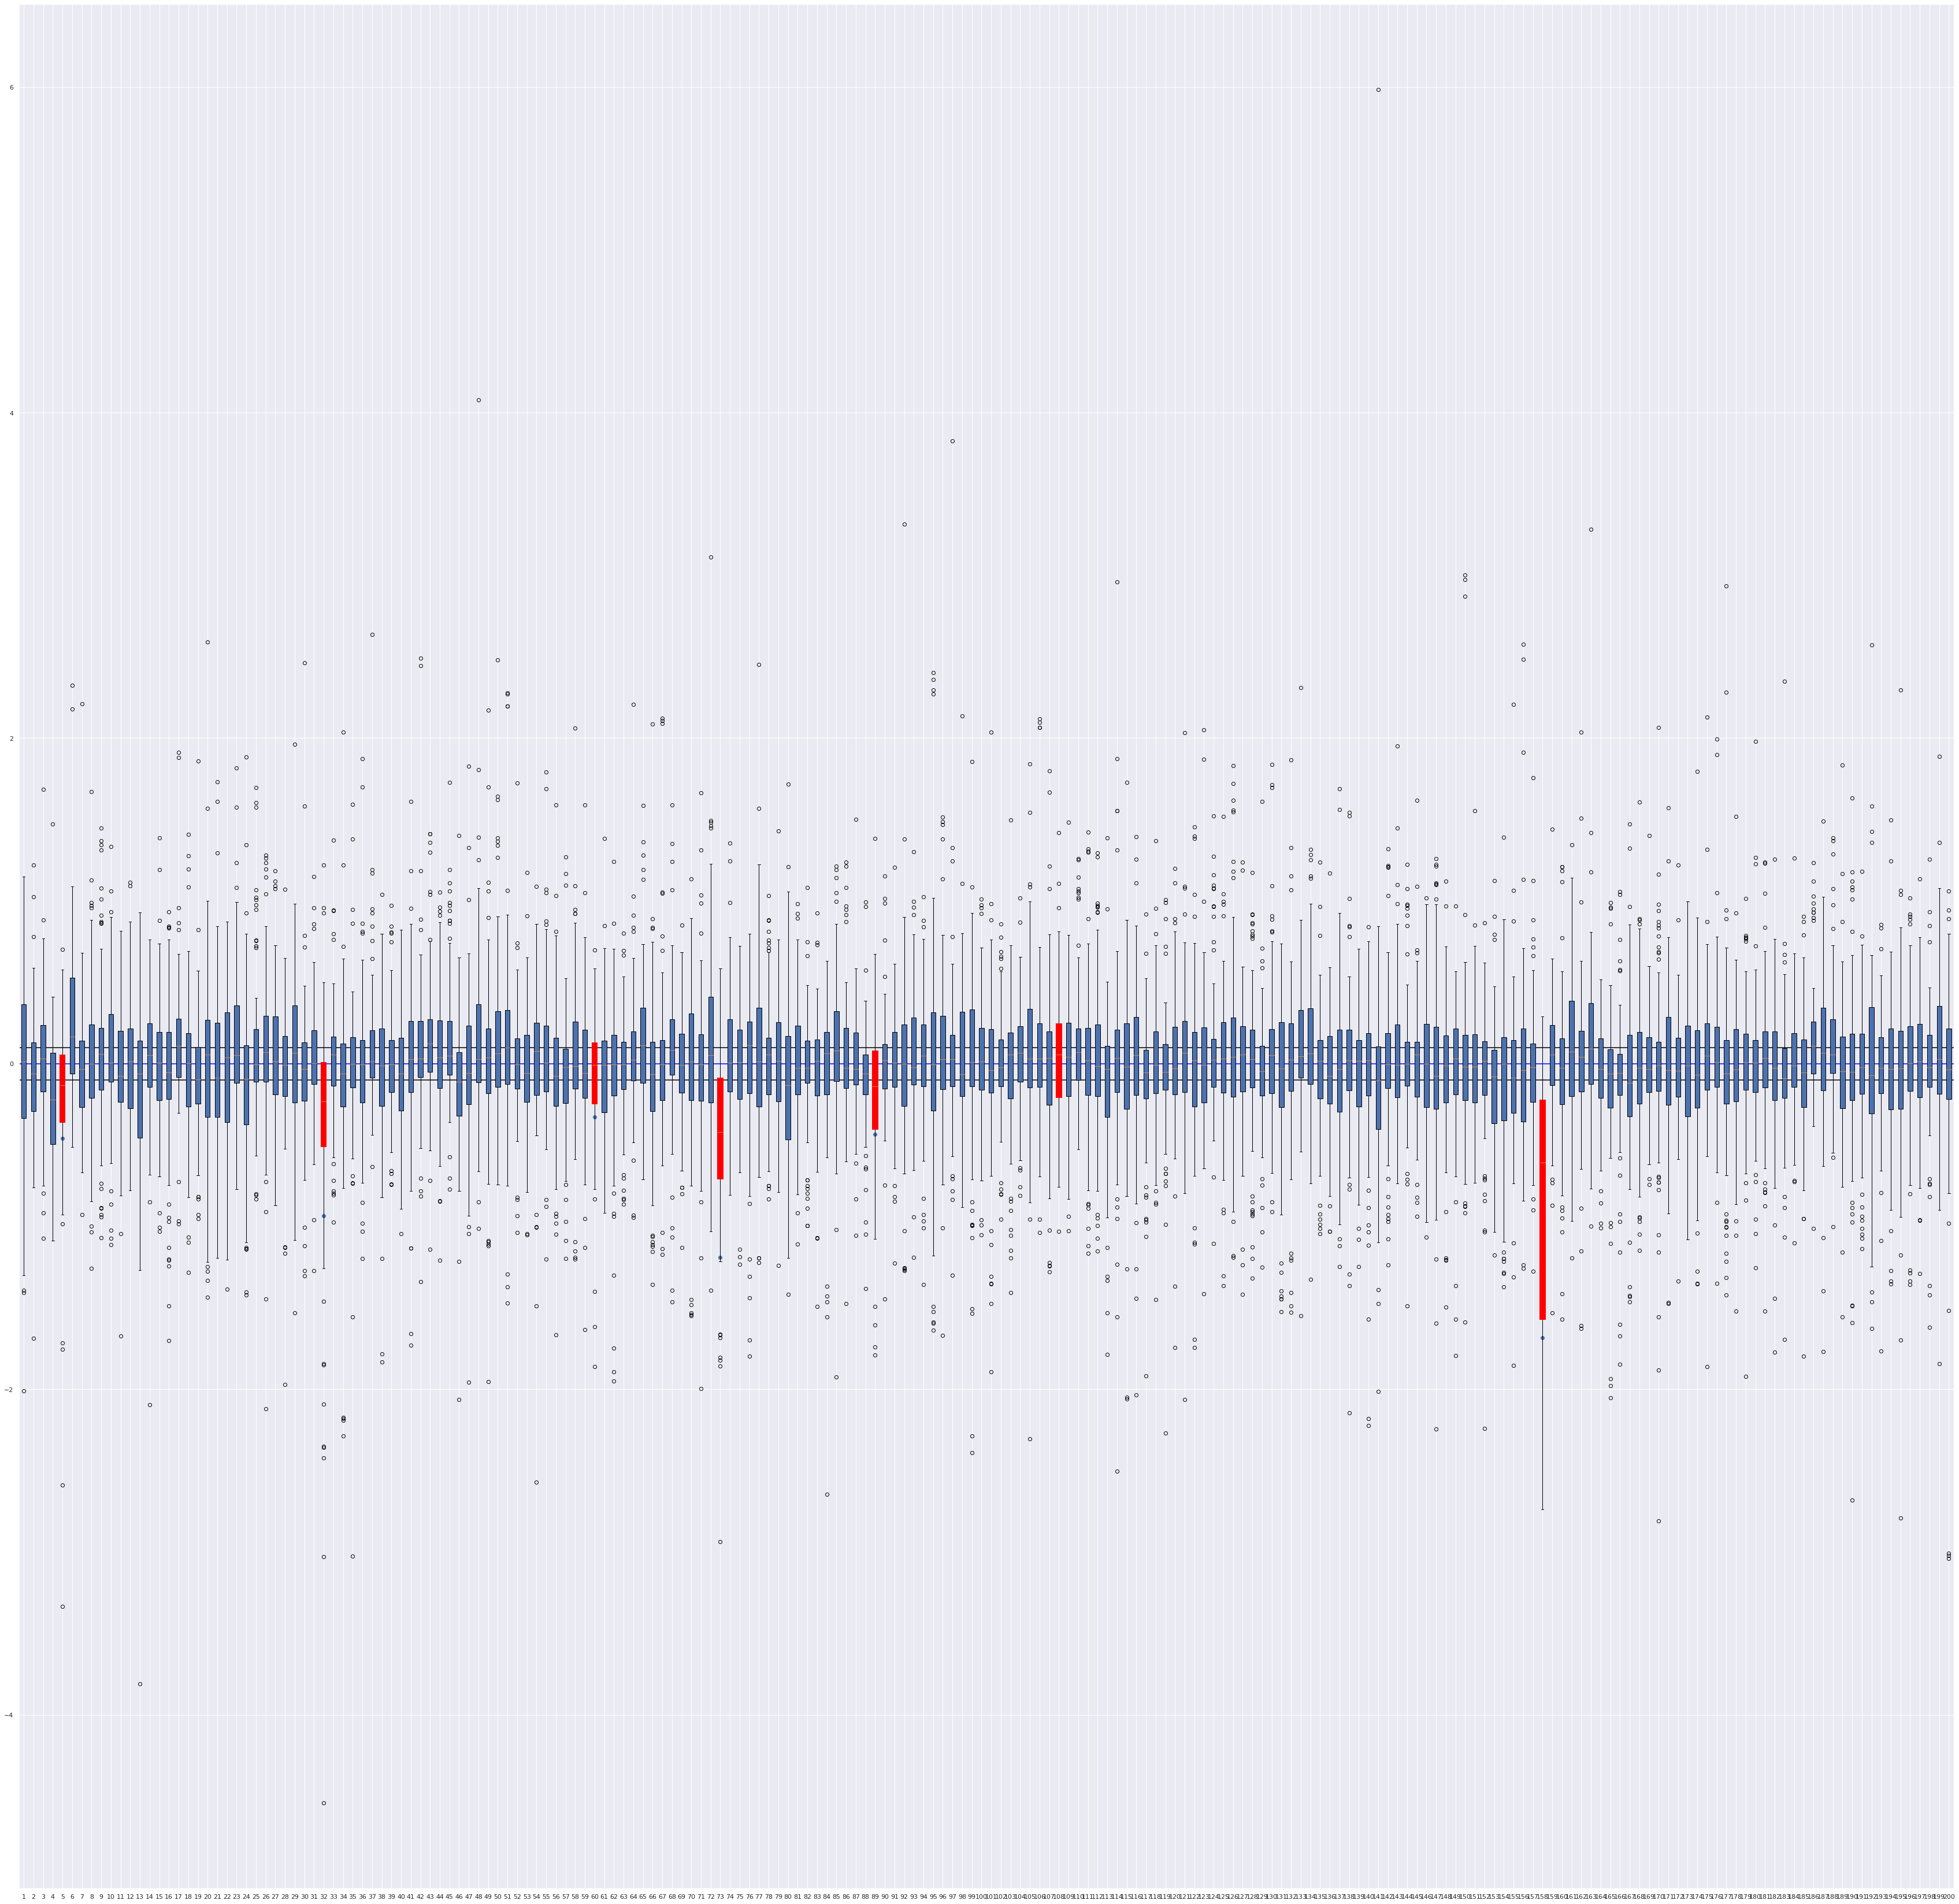

In [ ]:
to_plot = []
for i in range(proper_beta_samples_np.shape[0]):
    to_plot += [proper_beta_samples_np[i, :]]

print(len(to_plot))
print(to_plot[0].shape)
fig=plt.figure(1,figsize=(40 + int(d / 10),40 + int(d / 10)))
ax=fig.add_subplot(111)
bp=ax.boxplot(to_plot, patch_artist=True)

for i in causal:
    box = bp['boxes'][i]
    box.set(color='red', linewidth=2)
    box.set(facecolor = 'red')

plt.scatter(np.arange(len(to_plot)) + 1, betas)
plt.axhline(y=0.1, color='black', linestyle='-')
plt.axhline(y=0.0, color='blue', linestyle='-')
plt.axhline(y=-0.1, color='black', linestyle='-')

# plt.ylim([-5, 5])
fig.savefig('all_betas.pdf',bbox_inches='tight')
plt.show()

0.6778480449524582 validation
0.5062550819414163 validation correlation
0.5356185032463325 train
0.6059996653480776 train correlation
0.6521557760669701 test
0.5143698088966914 test correlation


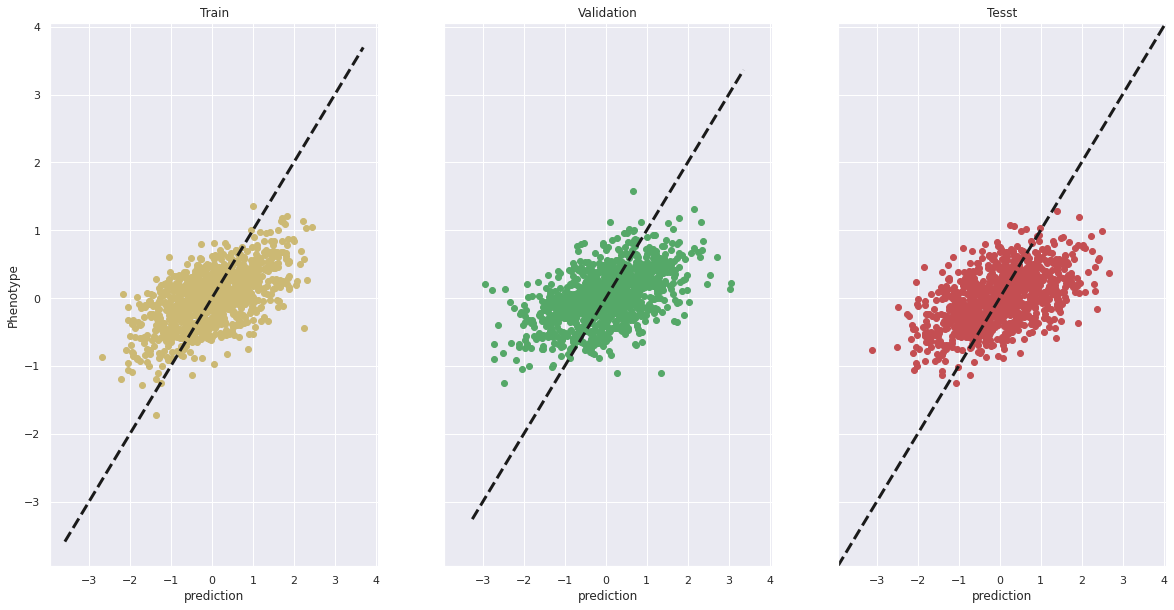

0.0702648701485267


In [ ]:
figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10))

# del per
per = np.dot(val_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)

RES_DICT['linear model validation'] = np.mean((val_phenotypes - per) ** 2)
print(np.mean((val_phenotypes - per) ** 2), 'validation')
print(pearsonr(val_phenotypes, per)[0], 'validation correlation')

del per

per = np.dot(train_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model train'] = np.mean((train_phenotypes - per) ** 2)
print(np.mean((train_phenotypes - per) ** 2), 'train')
print(pearsonr(train_phenotypes, per)[0], 'train correlation')


del per

per = np.dot(test_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model test'] = np.mean((test_phenotypes - per) ** 2)
print(np.mean((test_phenotypes - per) ** 2), 'test')
print(pearsonr(test_phenotypes, per)[0], 'test correlation')


for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

# plt.xlim(-1,1)
plt.show()
figure.savefig('proposed_model_res.pdf')

print(np.mean(np.abs(proper_beta_samples_mean - betas)))


In [ ]:
import pickle
    
try:
    res_file = open('res_dict', 'wb')
    pickle.dump(RES_DICT, res_file)
    res_file.close()
  
except:
    print("Something went wrong")

In [ ]:
# print(pd.read_csv("beta_marginal.csv").iloc['rs9482449',])
print(proper_beta_samples_mean[list(np.argsort(proper_beta_samples_mean)),][-20:,])
list(np.argsort(proper_beta_samples_mean))
pd.read_csv("beta_marginal.csv").iloc[list(np.argsort(proper_beta_samples_mean)),:].iloc[-20:,:]

[0.10503467 0.10635742 0.10740663 0.10918076 0.10946774 0.1158169
 0.12204145 0.12515102 0.13630627 0.13706748 0.13866027 0.14278446
 0.14353076 0.1503339  0.15358661 0.15360722 0.15789959 0.17043038
 0.1854883  0.2568373 ]


FileNotFoundError: ignored